Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Bagging

Bootstrap aggregation, or "Bagging," is an _ensemble_ learning technique.  Multiple regression or classifier learners are applied to separate training data samples that are drawn with replacement from the available training data.  The predictions of the learners are then summarized, by averaging in the case of continuous target variables, or by tallying the classification "votes" of classifiers, to get more accurate, lower variance, predictions.


Decision tree classifiers are often bagged.  Here we'll apply a very frequently used, and valuable, ensemble learning method of this sort called _Random Forest_.  We'll use the [Random Forest Classifier in Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).  

Like other ML algorithms, there are parameters to be set that affect the performance of Bagged algorithms. 

There is a variety of bagged methods.  Several are among the ensemble methods available from scikit-learn at [sklearn.ensemble](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble).

# Getting Packages

In [115]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC

import seaborn as sns
import pickle
import os
import shelve
%matplotlib inline


# Getting the Diabetes Data

We've used it before.

In [109]:
diabetes=pd.read_csv('../DATA/ML/dataset_37_diabetes.csv')
diabetes['target']=np.where(diabetes['class']=="tested_positive",1,0)
diabetes.drop('class',axis=1,inplace=True)

diabetes.head()
## Convert to np arrays

X=diabetes.iloc[:,:8].to_numpy()
y=diabetes.iloc[:,8].to_numpy()

,preg,plas,pres,skin,insu,mass,pedi,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Splitting the Data

Note that for Bagged applications, cross-validation is not necessarily so important. More on this, below.

In [110]:
## Training and test split
skf1=StratifiedShuffleSplit(n_splits=1,random_state=99) # Note, just a single random split here
for trainNdx,testNdx in skf1.split(X,y):
    Xtrain=X[trainNdx]
    ytrain=y[trainNdx]
    Xtest=X[testNdx]
    ytest=y[testNdx]

# Random Forest Classifier

The parameters that can be set and that affect Random Forest performance include the number of tree estimators to use, how large (or stump-like) they should be, and also _how many features should be used_ when fitting a tree.  

The Random Forest Algorithm _randomly samples_ a subset of available features to consider for each split in a tree. For a classifier, a commonly used hueristic is to limit the number of features considered to the square root of the number of available features. For a regression application, setting the maximum number of features to log$_2$(number of features).

In [40]:
# The parameters to be set include the number of trees to use,

rfClf = RandomForestClassifier(n_estimators=100, 
                             max_depth=5,
                             random_state=99,
                             max_features='sqrt',
                             bootstrap=True,
                             oob_score=True)

In [41]:
rfClfFit=rfClf.fit(Xtrain,ytrain)
ytrainPredProb=rfClfFit.predict_proba(Xtrain)
ytrainPred=rfClfFit.predict(Xtrain)
ytestPredProb=rfClfFit.predict_proba(Xtest)
ytestPred=rfClfFit.predict(Xtest)

In [42]:
print(classification_report(ytest, ytestPred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        50
           1       0.79      0.70      0.75        27

   micro avg       0.83      0.83      0.83        77
   macro avg       0.82      0.80      0.81        77
weighted avg       0.83      0.83      0.83        77



## ROC, AUC

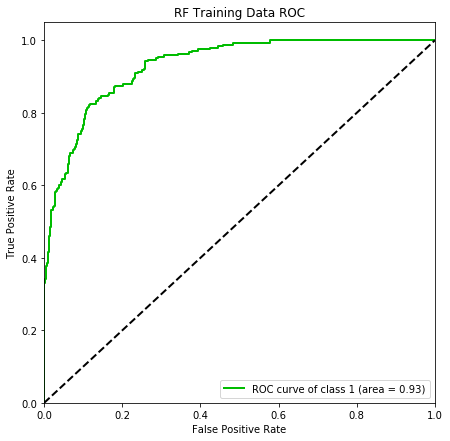

In [43]:
skplt.metrics.plot_roc(ytrain, ytrainPredProb, 
                      title="RF Training Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      plot_macro=False,
                      classes_to_plot=1)
plt.show();

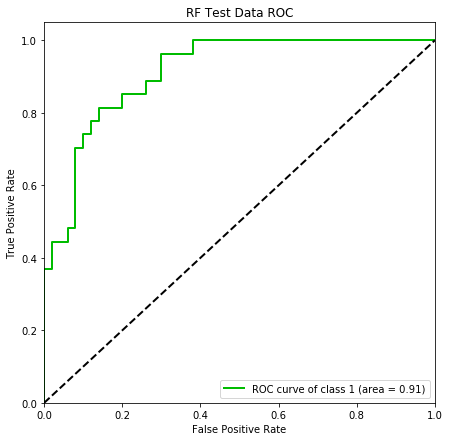

In [44]:
skplt.metrics.plot_roc(ytest, ytestPredProb, 
                      title="RF Test Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      plot_macro=False,
                      classes_to_plot=1)
plt.show();

## Feature Importances

Contributions of features to overall contributions to model fit, based on the the proportion of trees they contribute to.

See [ensembles: feature importances](https://scikit-learn.org/stable/modules/ensemble.html).

In [45]:
rfClfFit.feature_importances_

array([0.08556178, 0.38971454, 0.04710742, 0.04143429, 0.05559024,
       0.16388335, 0.08308965, 0.13361874])

A more organized presentation:

In [46]:
importances=pd.Series(rfClfFit.feature_importances_,index=diabetes.columns[:8]).sort_values(
            ascending=False)
print(importances)

plas    0.389715
mass    0.163883
age     0.133619
preg    0.085562
pedi    0.083090
insu    0.055590
pres    0.047107
skin    0.041434
dtype: float64


## Visualizing Feature Importances

In [54]:
importancesDF=importances.reset_index()
importancesDF.columns
importancesDF.rename({'index':'feature',0:'importance'},axis=1,
                    inplace=True)
importancesDF.columns

Index(['index', 0], dtype='object')

Index(['feature', 'importance'], dtype='object')

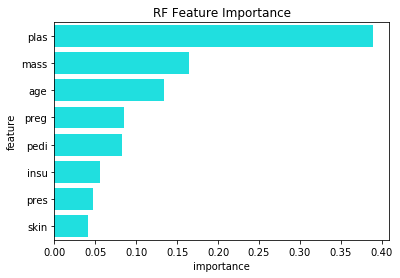

In [51]:
sns.barplot(x="importance", y="feature", data=importancesDF, color="cyan")
plt.title("RF Feature Importance")
plt.show();

## GridsearchCV

n_estimators=100, 
max_depth=5,
random_state=99,
max_features='sqrt',
bootstrap=True,
oob_score=True

In [62]:
param_grid={'n_estimators':[100],
            'max_depth':[5,6,7,8,9,10],
            'max_features':['sqrt'],
            'oob_score':['True']}
grid=GridSearchCV(rfClf,param_grid=param_grid,cv=20)
grid.fit(Xtrain,ytrain)
print("Best cross-validation accuracy: {:.4f}".format(grid.best_score_))
print("Test set score: {:.4f}".format(grid.score(Xtest, ytest)))
print("Best parameters: {}".format(grid.best_params_))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=99, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100], 'max_depth': [5, 6, 7, 8, 9, 10], 'max_features': ['sqrt'], 'oob_score': ['True']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best cross-validation accuracy: 0.7627
Test set score: 0.8312
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100, 'oob_score': 'True'}


## Out of Bag Error Estimation

The test error of a bagged model can be estimated using the observations that the bagged models don't used for training.  These are "out of bag" data. 

The "OOB" accuracy score:

In [37]:
rfClfFit.oob_score_

0.7250361794500724

## Accuracy Score On Test Data

In [39]:
rfClfFit.score(Xtest,ytest)

0.7402597402597403

In [117]:
from sklearn.ensemble import VotingClassifier

In [121]:

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
   estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
   voting='soft')
voting_clf.fit(Xtrain, ytrain)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
   clf.fit(Xtrain, ytrain)
   y_pred = clf.predict(Xtest)
   print(clf.__class__.__name__, accuracy_score(ytest, y_pred))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression 0.7792207792207793


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RandomForestClassifier 0.8051948051948052


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

SVC 0.6493506493506493


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

VotingClassifier 0.8181818181818182


# UDU: Random Forest Regression

Train a Random Forest Regression Model using the radon data.  Here's the [RF Regression API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).

In [63]:
!ls ../DATA/ML/

cervical.bak	  cervical.sdb.dir	   rBinLogData2.pkl
cervical.dat	  dataset_37_diabetes.csv  rBinLogData.pkl
cervical.dir	  DECART-patSat.csv	   risk_factors_cervical_cancer.csv
cervical.sdb.bak  mammography.csv
cervical.sdb.dat  radon.csv


In [68]:
radon = pd.read_csv("../DATA/ML/radon.csv").dropna()

In [69]:
radon.head()

,fips,state,county,lcanmort,radon,lnradon,obesity,over65,cursmoke,evrsmoke,hhincome
0,1001,AL,Autauga_County,97.0293,1.5,0.405465,31.3,10.2,26.4,48.60,56.58
1,13103,GA,Effingham_County,94.4043,0.5,-0.693147,31.1,8.0,26.6,49.65,63.26
2,13217,GA,Newton_County,91.8648,1.3,0.262364,32.1,9.9,27.4,49.95,51.18
3,13225,GA,Peach_County,93.6161,1.6,0.470004,30.1,9.8,27.5,47.55,41.73
4,21077,KY,Gallatin_County,141.4099,0.6,-0.510826,30.9,10.3,27.9,54.60,47.68


In [72]:
X=radon.iloc[:,5:].to_numpy()
y=radon.iloc[:,3].to_numpy()

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
rfregr = RandomForestRegressor(n_estimators=100, 
                             max_depth=5,
                             random_state=99,
                             max_features='sqrt',
                             bootstrap=True,
                             oob_score=True)
rfregr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=99, verbose=0, warm_start=False)

In [103]:
pd.DataFrame({'y_test': y_test, 'y_pred':rfregr.predict(X_test)}).tail()

,y_test,y_pred
715,72.9420,71.782838
716,59.8154,62.856292
717,48.4312,57.286772
718,74.1673,76.653350
719,71.1197,59.678232


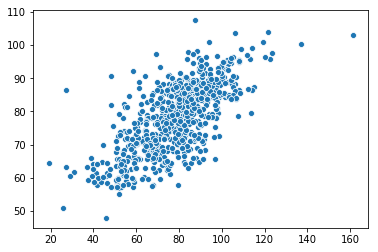

In [108]:
sns.scatterplot(y_test, rfregr.predict(X_test));

In [93]:
rfregr.score(X_test, y_test)

0.48575461622246535

In [95]:
rfregr.oob_score_

0.45644953086715734